In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [30]:
BATCH_SIZE = 22
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=100

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Original Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 656 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Bacterial spot rot', 'Black Rot', 'Downy Mildew', 'No disease']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(22, 256, 256, 3)
[0 2 2 2 2 2 3 1 2 2 2 2 0 0 2 1 2 2 2 0 3 0]


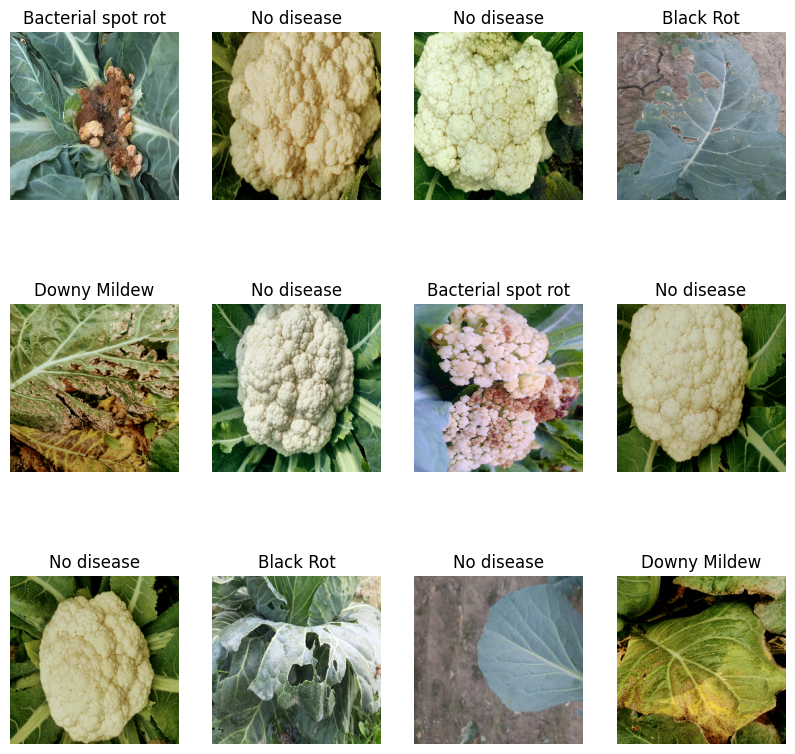

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

30

In [9]:
train_size = 0.8
len(dataset)*train_size

24.0

In [11]:
train_ds = dataset.take(24)
len(train_ds)

24

In [12]:
test_ds = dataset.skip(24)
len(test_ds)

6

In [13]:
val_size=0.1
len(dataset)*val_size

3.0

In [14]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [15]:
test_ds = test_ds.skip(3)
len(test_ds)

3

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

24

In [19]:
len(val_ds)


3

In [20]:
len(test_ds)

3

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(22, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (22, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (22, 254, 254, 22)        616       
                                                                 
 max_pooling2d (MaxPooling2  (22, 127, 127, 22)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (22, 125, 125, 64)        12736     
                                                                 
 max_pooling2d_1 (MaxPoolin  (22, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (22, 60, 60, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
24/24 [==============================] - 18s 761ms/step - loss: 0.1818 - accuracy: 0.9294 - val_loss: 0.2761 - val_accuracy: 0.8636
Epoch 2/100
24/24 [==============================] - 21s 888ms/step - loss: 0.1419 - accuracy: 0.9466 - val_loss: 0.1555 - val_accuracy: 0.9394
Epoch 3/100
24/24 [==============================] - 20s 812ms/step - loss: 0.1559 - accuracy: 0.9370 - val_loss: 0.2693 - val_accuracy: 0.9091
Epoch 4/100
24/24 [==============================] - 20s 820ms/step - loss: 0.1484 - accuracy: 0.9466 - val_loss: 0.2548 - val_accuracy: 0.8939
Epoch 5/100
24/24 [==============================] - 19s 786ms/step - loss: 0.1422 - accuracy: 0.9504 - val_loss: 0.2154 - val_accuracy: 0.9242
Epoch 6/100
24/24 [==============================] - 21s 887ms/step - loss: 0.1964 - accuracy: 0.9275 - val_loss: 0.6632 - val_accuracy: 0.7424
Epoch 7/100
24/24 [==============================] - 22s 901ms/step - loss: 0.1351 - accuracy: 0.9542 - val_loss: 0.3711 - val_accuracy:

In [32]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 1s 213ms/step - loss: 0.0189 - accuracy: 0.9839


In [33]:
scores

[0.01891423761844635, 0.9838709831237793]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 24}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
len(history.history['loss'])

100

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

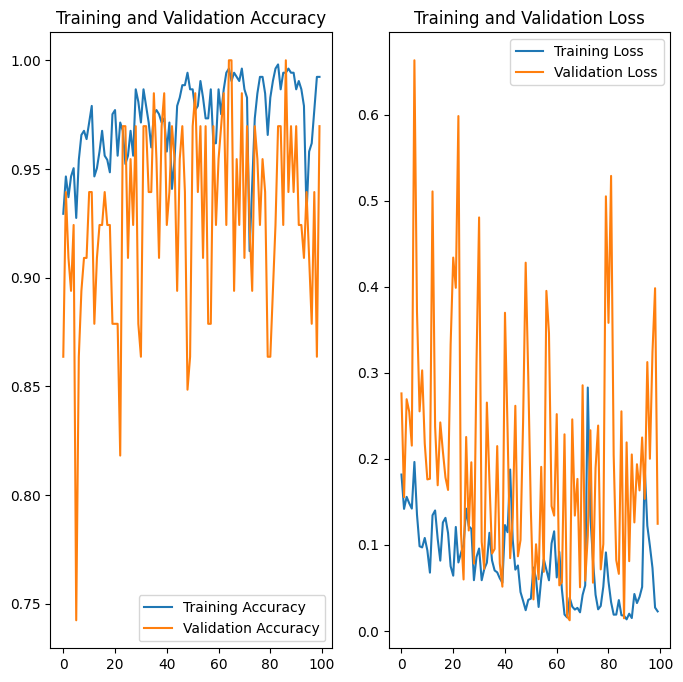

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Downy Mildew
1/1 [==============================] - 1s 571ms/step
predicted label: Downy Mildew


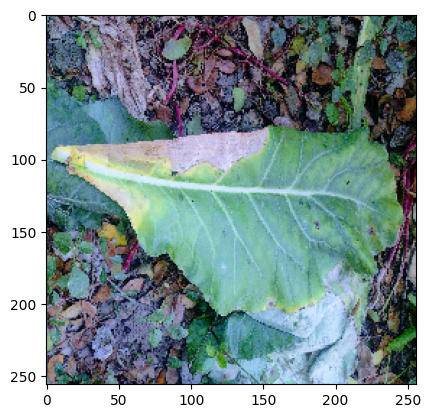

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 44ms/step


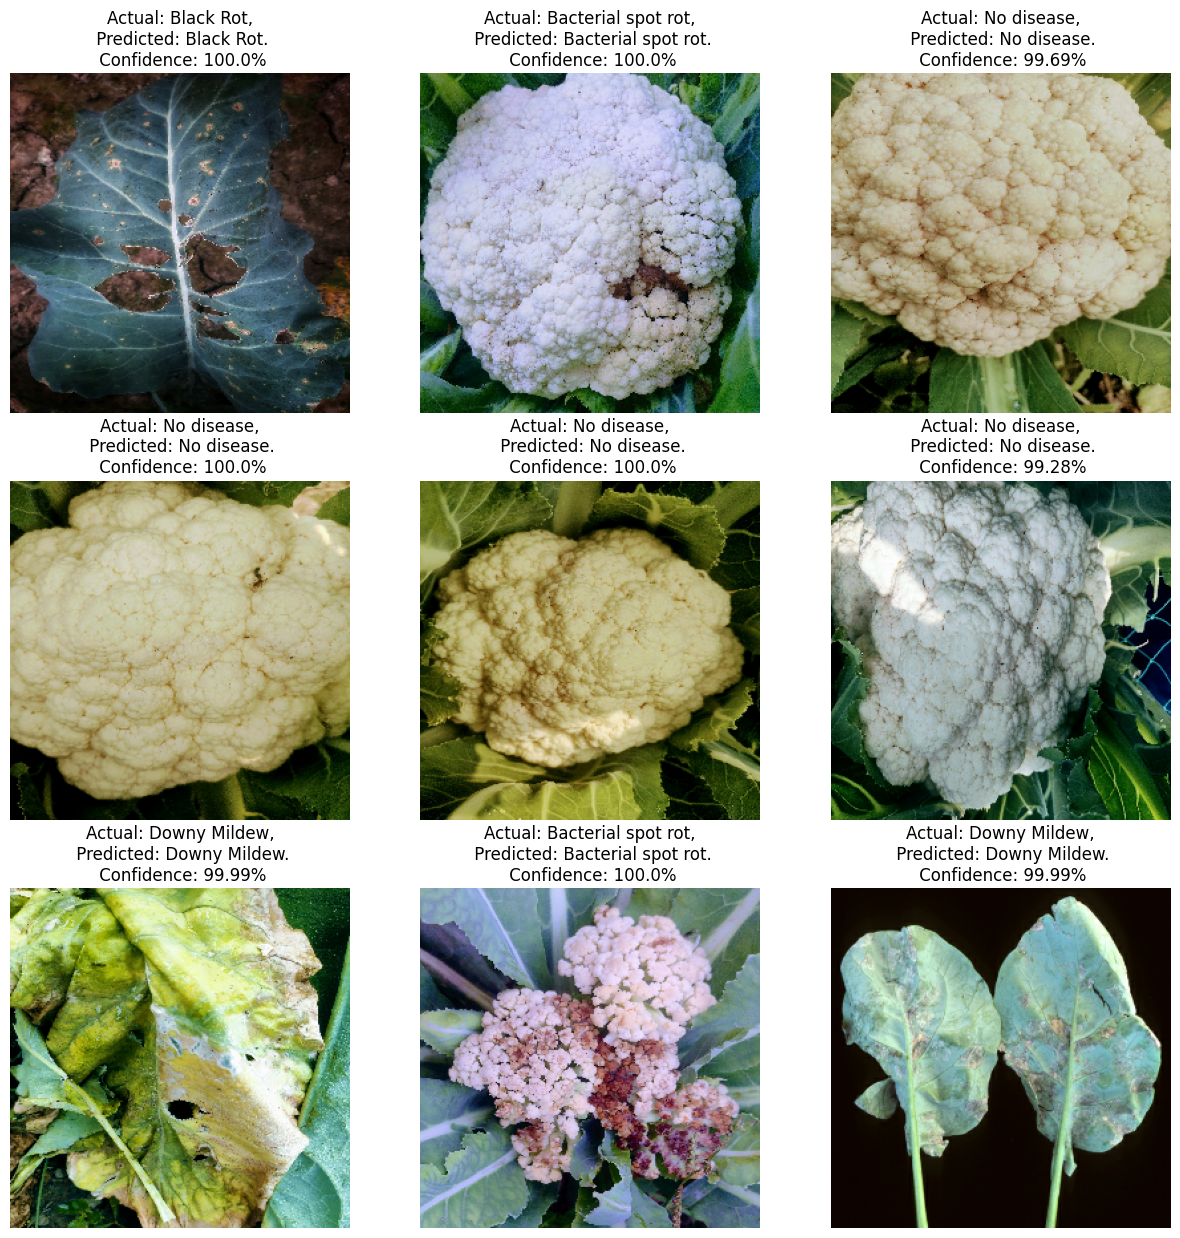

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [46]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets


In [47]:
model.save("../cauliflower.h5")

C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
